### Системы искусственного интеллекта. Лабораторная работа №3.
**Тема:** Generative Adversarial Network (GAN) на MNIST

**Выполнил:** Овчинников Дмитрий Олегович БВТ2201

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from torchvision.utils import make_grid

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Используемое устройство:", device)

Используемое устройство: cuda


In [ ]:
batch_size = 128
learning_rate = 0.0002
epochs = 50
latent_dim = 100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

fixed_noise = torch.randn(64, latent_dim, device=device)

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.main(x)
        return x.view(-1, 1, 28, 28)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

generator.apply(weights_init)
discriminator.apply(weights_init)

optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
criterion = nn.BCELoss()

G_losses, D_losses, D_real_losses, D_fake_losses = [], [], [], []

In [ ]:
def train_gan(epoch):
    generator.train()
    discriminator.train()

    for i, (real_imgs, _) in enumerate(train_loader):
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)

        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Обучение Дискриминатора
        optimizer_D.zero_grad()

        real_output = discriminator(real_imgs)
        d_loss_real = criterion(real_output, real_labels)

        noise = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = generator(noise)
        fake_output = discriminator(fake_imgs.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Обучение Генератора
        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = generator(noise)
        fake_output = discriminator(fake_imgs)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        optimizer_G.step()

        if i % 50 == 0:
            G_losses.append(g_loss.item())
            D_losses.append(d_loss.item())
            D_real_losses.append(d_loss_real.item())
            D_fake_losses.append(d_loss_fake.item())

    print(f"[Эпоха {epoch}/{epochs}] "
            f"Потеря D: {d_loss.item():.4f} | Потеря G: {g_loss.item():.4f} "
            f"D(реальные): {real_output.mean().item():.4f} | D(фейковые): {fake_output.mean().item():.4f}")

In [ ]:
def generate_images(epoch):
    """Визуализация сгенерированных изображений"""
    generator.eval()
    with torch.no_grad():
        fake_images = generator(fixed_noise).detach().cpu()
        fake_images = (fake_images + 1) / 2

        grid = make_grid(fake_images, nrow=8, normalize=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.permute(1, 2, 0))
        plt.title(f"Сгенерированные изображения — Эпоха {epoch}")
        plt.axis('off')
        plt.show()
    return grid

def plot_training_progress():
    """Графики потерь"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(G_losses, label='Потери Генератора')
    ax1.plot(D_losses, label='Потери Дискриминатора')
    ax1.set_title('Динамика потерь GAN')
    ax1.legend(); ax1.grid(True)

    ax2.plot(D_real_losses, label='D на реальных', alpha=0.7)
    ax2.plot(D_fake_losses, label='D на фейках', alpha=0.7)
    ax2.set_title('Разделение потерь D (реальные/фейковые)')
    ax2.legend(); ax2.grid(True)
    plt.show()

def show_real_vs_fake():
    """Сравнение реальных и сгенерированных изображений"""
    real_imgs, _ = next(iter(train_loader))
    real_imgs = real_imgs[:32]
    generator.eval()
    with torch.no_grad():
        fake_imgs = generator(torch.randn(32, latent_dim, device=device)).cpu()

    real_imgs = (real_imgs + 1) / 2
    fake_imgs = (fake_imgs + 1) / 2
    real_grid = make_grid(real_imgs, nrow=8)
    fake_grid = make_grid(fake_imgs, nrow=8)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(real_grid.permute(1, 2, 0)); ax1.set_title('Реальные изображения MNIST'); ax1.axis('off')
    ax2.imshow(fake_grid.permute(1, 2, 0)); ax2.set_title('Сгенерированные изображения GAN'); ax2.axis('off')
    plt.show()

Начало обучения GAN...

Архитектура генератора:
Generator(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

Архитектура дискриминатора:
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_featu

[Эпоха 1/50] Потеря D: 0.5082 | Потеря G: 6.3233 D(реальные): 0.9637 | D(фейковые): 0.0029

Генерация изображений после эпохи 1...


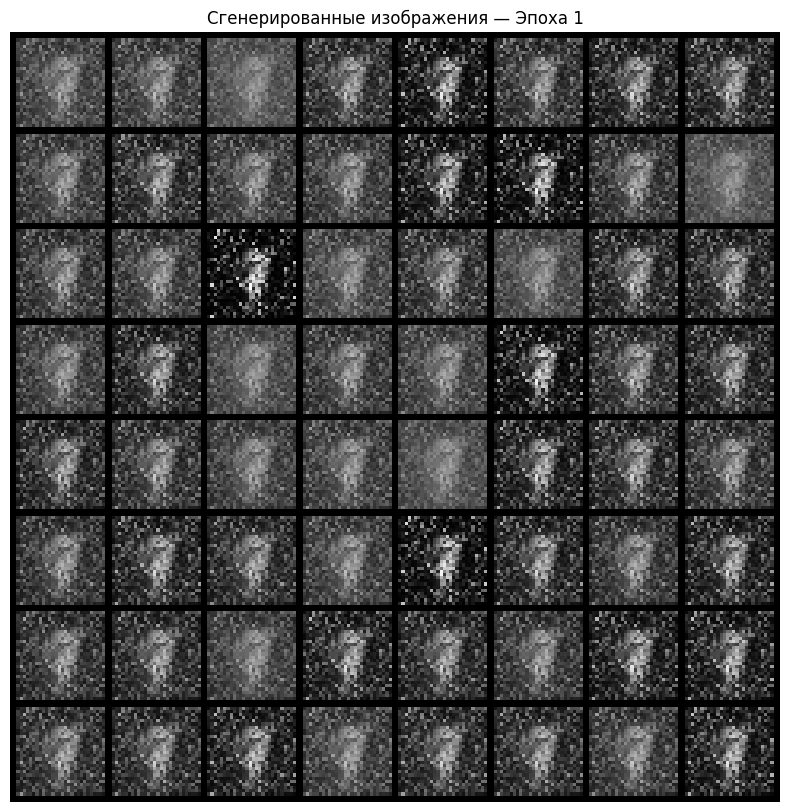

[Эпоха 2/50] Потеря D: 0.3647 | Потеря G: 2.8181 D(реальные): 0.8497 | D(фейковые): 0.0831
[Эпоха 3/50] Потеря D: 0.4240 | Потеря G: 2.7593 D(реальные): 0.8453 | D(фейковые): 0.1188
[Эпоха 4/50] Потеря D: 0.2732 | Потеря G: 2.8138 D(реальные): 0.8931 | D(фейковые): 0.0864
[Эпоха 5/50] Потеря D: 1.0878 | Потеря G: 2.6571 D(реальные): 0.6668 | D(фейковые): 0.0945
[Эпоха 6/50] Потеря D: 0.3198 | Потеря G: 2.7424 D(реальные): 0.9084 | D(фейковые): 0.0869
[Эпоха 7/50] Потеря D: 0.6196 | Потеря G: 4.0382 D(реальные): 0.9197 | D(фейковые): 0.0219
[Эпоха 8/50] Потеря D: 0.5642 | Потеря G: 1.7219 D(реальные): 0.7933 | D(фейковые): 0.2272
[Эпоха 9/50] Потеря D: 0.5861 | Потеря G: 1.7685 D(реальные): 0.7700 | D(фейковые): 0.1938
[Эпоха 10/50] Потеря D: 0.4754 | Потеря G: 2.5187 D(реальные): 0.8567 | D(фейковые): 0.1245

Генерация изображений после эпохи 10...


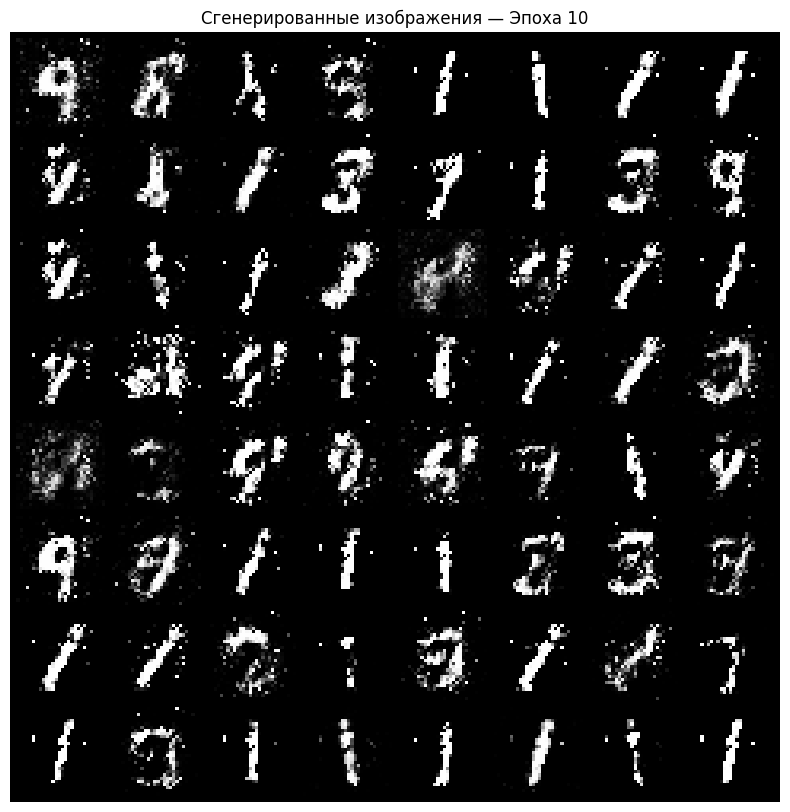

[Эпоха 11/50] Потеря D: 0.6843 | Потеря G: 2.8116 D(реальные): 0.8864 | D(фейковые): 0.0812
[Эпоха 12/50] Потеря D: 0.6666 | Потеря G: 1.6461 D(реальные): 0.7677 | D(фейковые): 0.2436
[Эпоха 13/50] Потеря D: 0.8982 | Потеря G: 1.9224 D(реальные): 0.6967 | D(фейковые): 0.1850
[Эпоха 14/50] Потеря D: 0.8358 | Потеря G: 1.7756 D(реальные): 0.8050 | D(фейковые): 0.2021
[Эпоха 15/50] Потеря D: 0.7530 | Потеря G: 1.3021 D(реальные): 0.6987 | D(фейковые): 0.3256
[Эпоха 16/50] Потеря D: 0.9176 | Потеря G: 1.5722 D(реальные): 0.8711 | D(фейковые): 0.2470
[Эпоха 17/50] Потеря D: 0.9347 | Потеря G: 1.3944 D(реальные): 0.6933 | D(фейковые): 0.2969
[Эпоха 18/50] Потеря D: 0.8279 | Потеря G: 1.8157 D(реальные): 0.7631 | D(фейковые): 0.1871
[Эпоха 19/50] Потеря D: 0.9195 | Потеря G: 1.2694 D(реальные): 0.7366 | D(фейковые): 0.3194
[Эпоха 20/50] Потеря D: 1.0444 | Потеря G: 1.3404 D(реальные): 0.6440 | D(фейковые): 0.2980

Генерация изображений после эпохи 20...


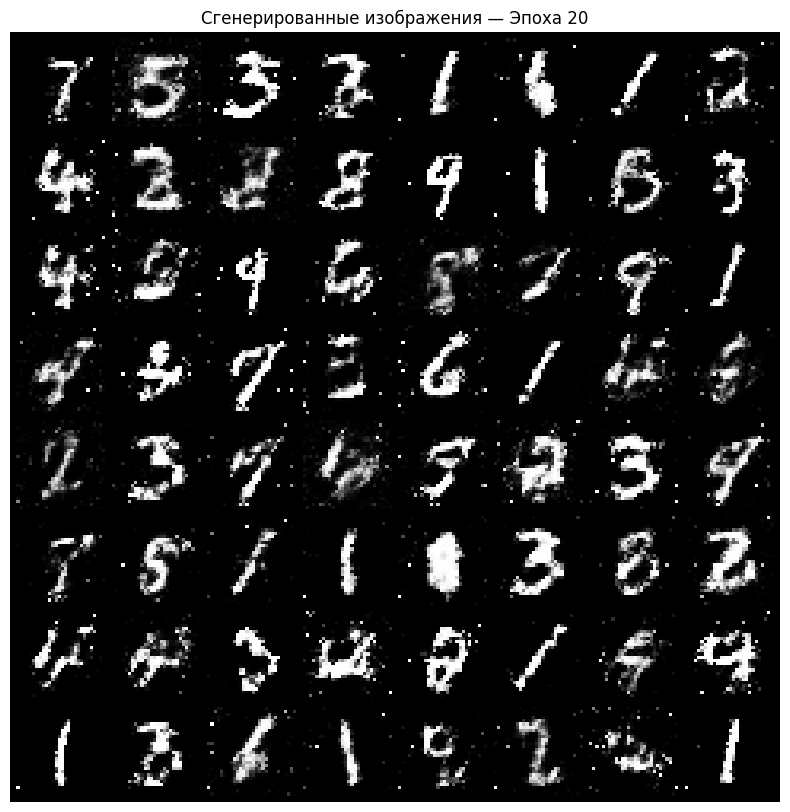

[Эпоха 21/50] Потеря D: 0.9640 | Потеря G: 1.6036 D(реальные): 0.7456 | D(фейковые): 0.2398
[Эпоха 22/50] Потеря D: 0.9622 | Потеря G: 1.4167 D(реальные): 0.7578 | D(фейковые): 0.2983
[Эпоха 23/50] Потеря D: 1.1427 | Потеря G: 0.9973 D(реальные): 0.4924 | D(фейковые): 0.4176
[Эпоха 24/50] Потеря D: 1.0162 | Потеря G: 1.0133 D(реальные): 0.6463 | D(фейковые): 0.4081
[Эпоха 25/50] Потеря D: 1.0814 | Потеря G: 1.2677 D(реальные): 0.6039 | D(фейковые): 0.3269
[Эпоха 26/50] Потеря D: 1.0473 | Потеря G: 1.3828 D(реальные): 0.7370 | D(фейковые): 0.2946
[Эпоха 27/50] Потеря D: 0.9820 | Потеря G: 1.2429 D(реальные): 0.6922 | D(фейковые): 0.3340
[Эпоха 28/50] Потеря D: 1.0588 | Потеря G: 1.3285 D(реальные): 0.5939 | D(фейковые): 0.3204
[Эпоха 29/50] Потеря D: 0.9408 | Потеря G: 1.2796 D(реальные): 0.6632 | D(фейковые): 0.3234
[Эпоха 30/50] Потеря D: 0.9024 | Потеря G: 1.1363 D(реальные): 0.7221 | D(фейковые): 0.3757

Генерация изображений после эпохи 30...


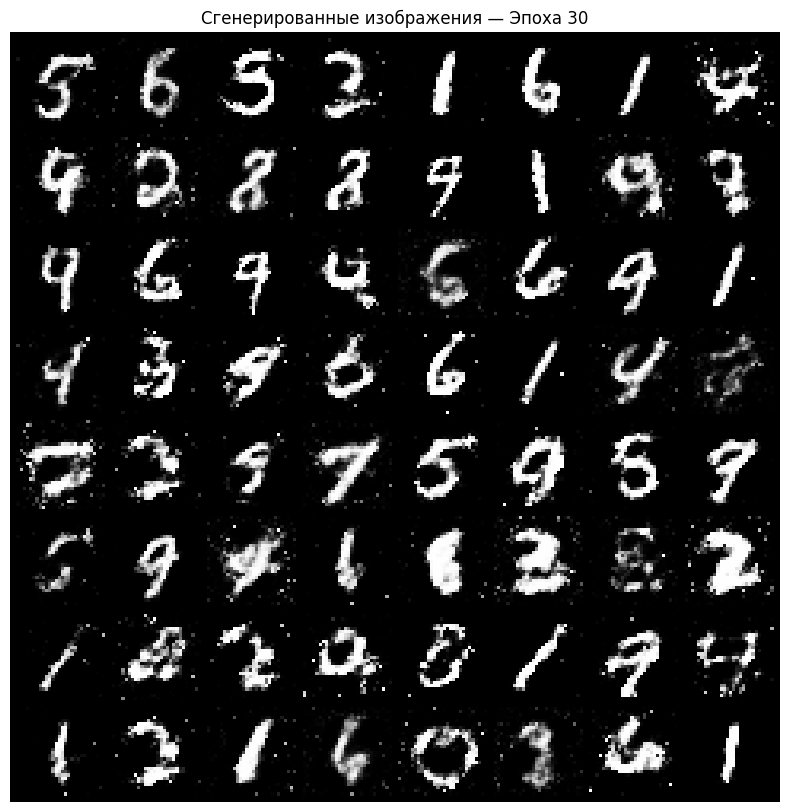

[Эпоха 31/50] Потеря D: 1.0735 | Потеря G: 1.5234 D(реальные): 0.7021 | D(фейковые): 0.2571
[Эпоха 32/50] Потеря D: 1.0302 | Потеря G: 1.4753 D(реальные): 0.6079 | D(фейковые): 0.2659
[Эпоха 33/50] Потеря D: 1.0667 | Потеря G: 1.7318 D(реальные): 0.7333 | D(фейковые): 0.2210
[Эпоха 34/50] Потеря D: 0.9832 | Потеря G: 1.2674 D(реальные): 0.6675 | D(фейковые): 0.3231
[Эпоха 35/50] Потеря D: 1.0021 | Потеря G: 1.6868 D(реальные): 0.7017 | D(фейковые): 0.2198
[Эпоха 36/50] Потеря D: 1.2055 | Потеря G: 0.9124 D(реальные): 0.5039 | D(фейковые): 0.4520
[Эпоха 37/50] Потеря D: 1.1029 | Потеря G: 1.4697 D(реальные): 0.7509 | D(фейковые): 0.2698
[Эпоха 38/50] Потеря D: 1.0348 | Потеря G: 1.4986 D(реальные): 0.6958 | D(фейковые): 0.2701
[Эпоха 39/50] Потеря D: 0.9396 | Потеря G: 1.0102 D(реальные): 0.6510 | D(фейковые): 0.4143
[Эпоха 40/50] Потеря D: 1.0861 | Потеря G: 0.9148 D(реальные): 0.5527 | D(фейковые): 0.4392

Генерация изображений после эпохи 40...


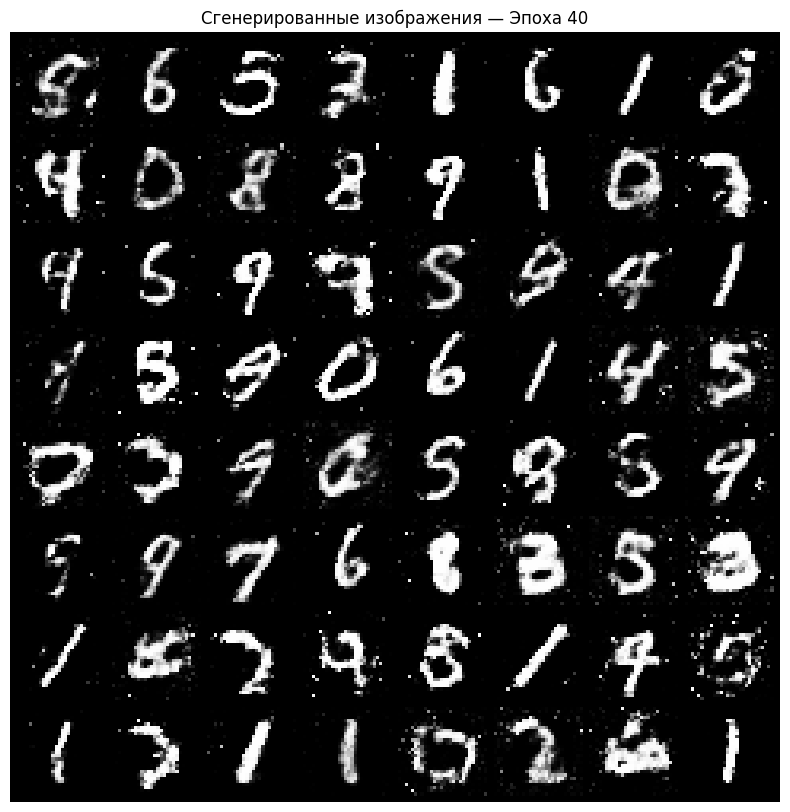

[Эпоха 41/50] Потеря D: 1.2342 | Потеря G: 1.2147 D(реальные): 0.7281 | D(фейковые): 0.3422
[Эпоха 42/50] Потеря D: 1.0148 | Потеря G: 1.3048 D(реальные): 0.7035 | D(фейковые): 0.3028
[Эпоха 43/50] Потеря D: 1.0230 | Потеря G: 1.2539 D(реальные): 0.6606 | D(фейковые): 0.3282
[Эпоха 44/50] Потеря D: 1.0819 | Потеря G: 1.2655 D(реальные): 0.6074 | D(фейковые): 0.3272
[Эпоха 45/50] Потеря D: 1.0684 | Потеря G: 1.0233 D(реальные): 0.6215 | D(фейковые): 0.4037
[Эпоха 46/50] Потеря D: 1.1273 | Потеря G: 1.2831 D(реальные): 0.6523 | D(фейковые): 0.3185
[Эпоха 47/50] Потеря D: 1.0185 | Потеря G: 1.1998 D(реальные): 0.5805 | D(фейковые): 0.3444
[Эпоха 48/50] Потеря D: 1.0745 | Потеря G: 1.1317 D(реальные): 0.5811 | D(фейковые): 0.3603
[Эпоха 49/50] Потеря D: 1.1095 | Потеря G: 1.1897 D(реальные): 0.6771 | D(фейковые): 0.3484
[Эпоха 50/50] Потеря D: 1.0002 | Потеря G: 1.0820 D(реальные): 0.6160 | D(фейковые): 0.3744

Генерация изображений после эпохи 50...


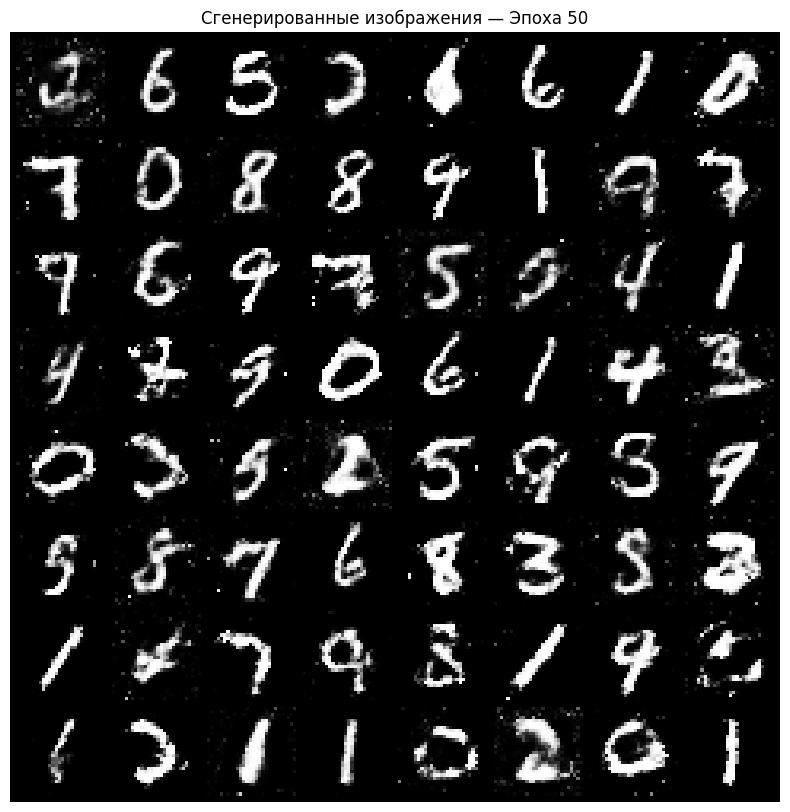


ОБУЧЕНИЕ GAN ЗАВЕРШЕНО


In [9]:
print("Начало обучения GAN...")
print("\nАрхитектура генератора:"); print(generator)
print("\nАрхитектура дискриминатора:"); print(discriminator)

for epoch in range(1, epochs + 1):
    train_gan(epoch)
    if epoch % 10 == 0 or epoch == 1:
        print(f"\nГенерация изображений после эпохи {epoch}...")
        generate_images(epoch)

print("\n" + "="*60)
print("ОБУЧЕНИЕ GAN ЗАВЕРШЕНО")
print("="*60)


Графики потерь:


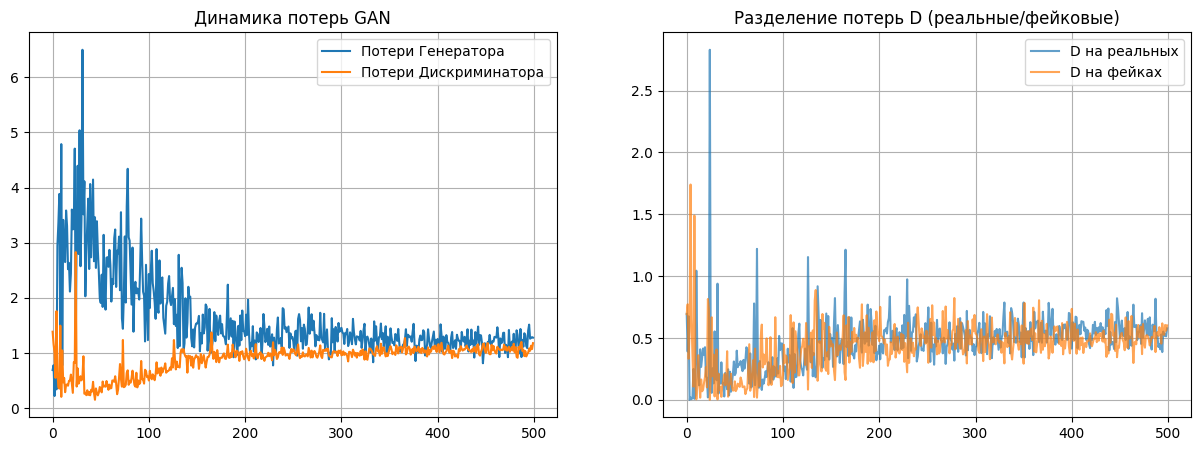


Сравнение реальных и фейковых изображений:


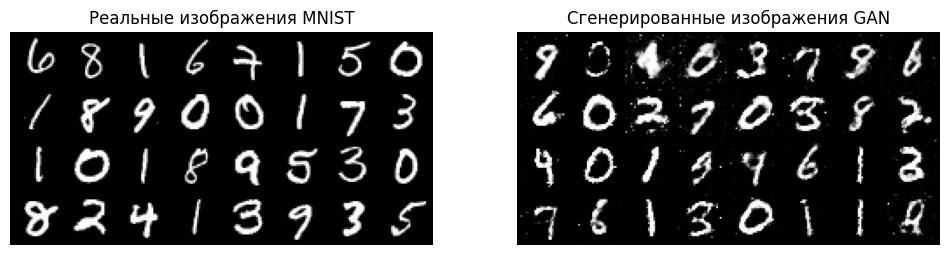


Генерация множества примеров:


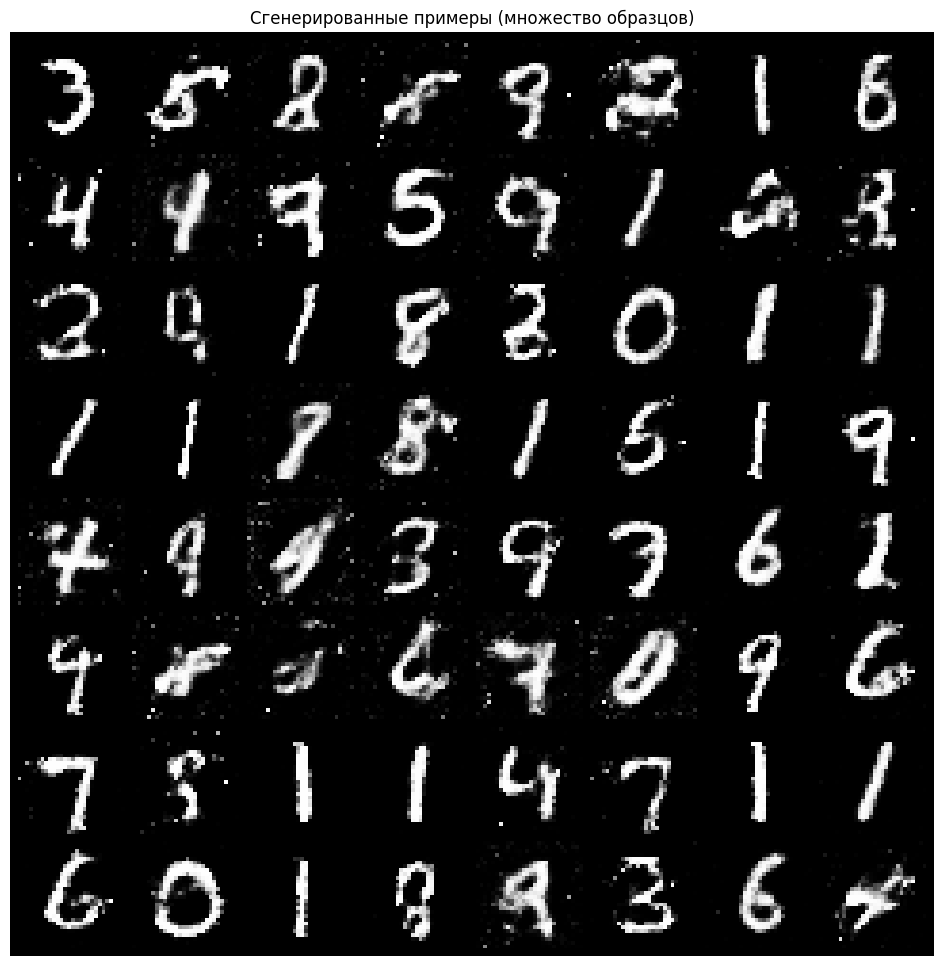

In [19]:
print("\nГрафики потерь:")
plot_training_progress()

print("\nСравнение реальных и фейковых изображений:")
show_real_vs_fake()

def generate_multiple_samples(num_samples=64):
    generator.eval()
    with torch.no_grad():
        fake_images = generator(torch.randn(num_samples, latent_dim, device=device)).cpu()
        fake_images = (fake_images + 1) / 2
        grid = make_grid(fake_images, nrow=8)
        plt.figure(figsize=(12, 12))
        plt.imshow(grid.permute(1, 2, 0))
        plt.title('Сгенерированные примеры (множество образцов)')
        plt.axis('off')
        plt.show()

print("\nГенерация множества примеров:")
generate_multiple_samples(64)